In [8]:
import argparse
import os

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

import datasets
from positional_embeddings import PositionalEmbedding


class Block(nn.Module):
    def __init__(self, size: int):
        super().__init__()

        self.ff = nn.Linear(size, size)
        self.act = nn.GELU()

    def forward(self, x: torch.Tensor):
        return x + self.act(self.ff(x))


class MLP(nn.Module):
    def __init__(self, hidden_size: int = 128, hidden_layers: int = 3, emb_size: int = 128,
                 time_emb: str = "sinusoidal", input_emb: str = "sinusoidal"):
        super().__init__()

        self.time_mlp = PositionalEmbedding(emb_size, time_emb)
        self.input_mlp1 = PositionalEmbedding(emb_size, input_emb, scale=25.0)
        self.input_mlp2 = PositionalEmbedding(emb_size, input_emb, scale=25.0)

        concat_size = len(self.time_mlp.layer) + \
            len(self.input_mlp1.layer) + len(self.input_mlp2.layer)
        layers = [nn.Linear(concat_size, hidden_size), nn.GELU()]
        for _ in range(hidden_layers):
            layers.append(Block(hidden_size))
        layers.append(nn.Linear(hidden_size, 2))
        self.joint_mlp = nn.Sequential(*layers)

    def forward(self, x, t):
        x1_emb = self.input_mlp1(x[:, 0])
        x2_emb = self.input_mlp2(x[:, 1])
        t_emb = self.time_mlp(t)
        x = torch.cat((x1_emb, x2_emb, t_emb), dim=-1)
        x = self.joint_mlp(x)
        return x


class NoiseScheduler():
    def __init__(self,
                 num_timesteps=1000,
                 beta_start=0.0001,
                 beta_end=0.02,
                 beta_schedule="linear"):

        self.num_timesteps = num_timesteps
        if beta_schedule == "linear":
            self.betas = torch.linspace(
                beta_start, beta_end, num_timesteps, dtype=torch.float32)
        elif beta_schedule == "quadratic":
            self.betas = torch.linspace(
                beta_start ** 0.5, beta_end ** 0.5, num_timesteps, dtype=torch.float32) ** 2

        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(
            self.alphas_cumprod[:-1], (1, 0), value=1.)

        # required for self.add_noise
        self.sqrt_alphas_cumprod = self.alphas_cumprod ** 0.5
        self.sqrt_one_minus_alphas_cumprod = (1 - self.alphas_cumprod) ** 0.5

        # required for reconstruct_x0
        self.sqrt_inv_alphas_cumprod = torch.sqrt(1 / self.alphas_cumprod)
        self.sqrt_inv_alphas_cumprod_minus_one = torch.sqrt(
            1 / self.alphas_cumprod - 1)

        # required for q_posterior
        self.posterior_mean_coef1 = self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)
        self.posterior_mean_coef2 = (1. - self.alphas_cumprod_prev) * torch.sqrt(self.alphas) / (1. - self.alphas_cumprod)



    def __len__(self):
        return self.num_timesteps


# Sampling normal distributions 101

$x \sim \mathcal{N}(\mu, \sigma^2)$

$x = \mu + \sigma z \quad , \; z \sim \mathcal{N}(0, 1)$ 

# Forward process

![diff](static/diffusion_start.png)

$$q(x_t | x_{t-1}) = \mathcal{N}\left(\sqrt{1-\beta_t}x_{t-1}, \beta_t \mathbf{I} \right)$$

Where:

- $\beta_t$ goes from 0...1
- $\mu = \sqrt{1-\beta_t}x_{t-1}$ 
- $\sigma = \sqrt{\beta_t} \mathbf{I}$ 

Sampling from $q$:

$$x_t = \sqrt{1-\beta_t}x_{t-1} + \sqrt{\beta_t} \mathbf{I} z \quad , \; z \sim \mathcal{N}(0, 1)$$ 




# What else can we infer?

![diff](static/diffusion_post.png)

Solving the recurrent equation we get that:


$$x_t = \sqrt{\vphantom{1}\bar{\alpha}_t} x_0 +  \sqrt{1 - \bar{\alpha}_t} \bar{z} \quad , \; \bar{z} \sim \mathcal{N}(0, 1)$$ 


so $x_t$ come from a distribution that looks like this:

$$q(x_t) = \mathcal{N}\left(\sqrt{\vphantom{1}\bar{\alpha}_t} x_0, \left(1 - \bar{\alpha}_t \right) \mathbf{I} \right)$$

and we also know:

$$q(x_{t-1}) = \mathcal{N}\left(\sqrt{\vphantom{1}\bar{\alpha}_{t-1}} x_0, \left(1 - \bar{\alpha}_{t-1} \right) \mathbf{I} \right)$$

recapping, we know:
- $q(x_t | x_{t-1})$
- $q(x_t)$ 
- $q(x_{t-1})$

Using Bayes theorem:

$$q(x_{t-1} \vert x_{t}) = \frac{q(x_t \vert x_{t-1})q(x_{t-1})}{q(x_{t})}$$

substituting the known PDFs we compute the $\mu$ and $\sigma$ of $q(x_{t-1} \vert x_{t})$:

$$\begin{aligned} 
\tilde{\mu}_t(x_t, x_0) & = \frac{(1-\bar{\alpha}_{t-1})\sqrt{\vphantom{1}\alpha_t}}{1-\bar{\alpha}_t} x_t + \frac{\beta_t \sqrt{\vphantom{1}\bar{\alpha}_{t-1}}}{1-\bar{\alpha}_t} x_0
\\
\hspace{1cm} \\

\tilde{\sigma}_t  & = \beta_t\frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_t} 
\end{aligned}$$


# Sampling from $q(x_t)$

$$x_t = \sqrt{\vphantom{1}\bar{\alpha}_t} x_0 +  \bar{z}\sqrt{1 - \bar{\alpha}_t}$$

In [12]:
def add_noise(noise_scheduler, x_start, x_noise, timesteps):
    s1 = noise_scheduler.sqrt_alphas_cumprod[timesteps]
    s2 = noise_scheduler.sqrt_one_minus_alphas_cumprod[timesteps]
    s1 = s1.reshape(-1, 1)
    s2 = s2.reshape(-1, 1)
    return s1 * x_start + s2 * x_noise

# Sampling $q(x_t)$ to estimate $\hat{x}_0$

$$q(x_t) = \mathcal{N}\left(\sqrt{\vphantom{1}\bar{\alpha}_t} x_0, \left(1 - \bar{\alpha}_t \right) \mathbf{I} \right)\\
\therefore \\
x_t = \sqrt{\vphantom{1}\bar{\alpha}_t} \hat{x}_0 +  \bar{z}\sqrt{1 - \bar{\alpha}_t} \\
\therefore \\
 \hat{x}_0 = \frac{1}{\sqrt{\vphantom{1}\bar{\alpha}_t}}x_t -
                        \bar{z}\sqrt{\frac{1}{\bar{\alpha}_t} - 1} $$

In [9]:

def reconstruct_x0(noise_scheduler, x_t, t, noise):
    s1 = noise_scheduler.sqrt_inv_alphas_cumprod[t]
    s2 = noise_scheduler.sqrt_inv_alphas_cumprod_minus_one[t]
    s1 = s1.reshape(-1, 1)
    s2 = s2.reshape(-1, 1)
    return s1 * x_t - s2 * noise

# Computing $\mu$ and $\sigma$ of $q(x_{t-1} \vert x_t)$

$$\begin{aligned} 
\tilde{\mu}_t(x_t, x_0) & = \frac{(1-\bar{\alpha}_{t-1})\sqrt{\vphantom{1}\alpha_t}}{1-\bar{\alpha}_t} x_t + \frac{\beta_t \sqrt{\vphantom{1}\bar{\alpha}_{t-1}}}{1-\bar{\alpha}_t} \hat{x}_0
\\
\hspace{1cm} \\

\tilde{\sigma}_t  & = \beta_t\frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_t} 
\end{aligned}$$

In [10]:
def q_posterior_mean(noise_scheduler, x_0, x_t, t):
    s1 = noise_scheduler.posterior_mean_coef1[t]
    s2 = noise_scheduler.posterior_mean_coef2[t]
    s1 = s1.reshape(-1, 1)
    s2 = s2.reshape(-1, 1)
    mu = s1 * x_0 + s2 * x_t
    return mu

def q_posterior_variance(noise_scheduler, t):
    if t == 0:
        return 0

    variance = noise_scheduler.betas[t] * (1. - noise_scheduler.alphas_cumprod_prev[t]) / (1. - noise_scheduler.alphas_cumprod[t])
    variance = variance.clamp(1e-20)
    return variance

# Sample $q(x_{t-1} \vert x_t)$

In [ ]:

def diffusion_step(noise_scheduler, model_output, timestep, sample):
    t = timestep
    pred_original_sample = reconstruct_x0(noise_scheduler, sample, t, model_output)

    # compute posterior distribution

    mean = q_posterior_mean(noise_scheduler, pred_original_sample, sample, t)
    variance = (q_posterior_variance(noise_scheduler, t) ** 0.5) 

    # sample from the distribution    
    noise = torch.randn_like(model_output)
    pred_prev_sample = mean + variance * noise

    return pred_prev_sample

In [15]:
class Config():
    def __init__(self):
        self.experiment_name = "base"
        self.dataset = "dino"
        self.train_batch_size = 32
        self.eval_batch_size = 1000
        self.num_epochs = 200
        self.learning_rate = 1e-3
        self.num_timesteps = 50
        self.beta_schedule = "linear"
        self.embedding_size = 128
        self.hidden_size = 128
        self.hidden_layers = 3
        self.time_embedding = "sinusoidal"
        self.input_embedding = "sinusoidal"
        self.save_images_step = 1

config = Config()        
print(config)
dataset = datasets.get_dataset(config.dataset)
dataloader = DataLoader(
    dataset, batch_size=config.train_batch_size, shuffle=True, drop_last=True)

model = MLP(
    hidden_size=config.hidden_size,
    hidden_layers=config.hidden_layers,
    emb_size=config.embedding_size,
    time_emb=config.time_embedding,
    input_emb=config.input_embedding)

noise_scheduler = NoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_schedule=config.beta_schedule)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,
)

global_step = 0
frames = []
losses = []
print("Training model...")
for epoch in range(config.num_epochs):
    model.train()
    for step, batch in enumerate(dataloader):
        batch = batch[0]
        noise = torch.randn(batch.shape)
        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (batch.shape[0],)
        ).long()

        noisy = add_noise(noise_scheduler, batch, noise, timesteps)
        noise_pred = model(noisy, timesteps)
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)

        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()

        logs = {"loss": loss.detach().item(), "step": global_step}
        losses.append(loss.detach().item())
        global_step += 1

    if epoch % config.save_images_step == 0 or epoch == config.num_epochs - 1:
        # generate data with the model to later visualize the learning process
        model.eval()
        sample = torch.randn(config.eval_batch_size, 2)
        timesteps = list(range(len(noise_scheduler)))[::-1]
        for i, t in enumerate(timesteps):
            t = torch.from_numpy(np.repeat(t, config.eval_batch_size)).long()
            with torch.no_grad():
                residual = model(sample, t)            
            sample = diffusion_step(noise_scheduler, residual, t[0], sample)
        frames.append(sample.numpy())


Training model...


In [ ]:

print("Saving model...")
outdir = f"exps/{config.experiment_name}"
os.makedirs(outdir, exist_ok=True)
torch.save(model.state_dict(), f"{outdir}/model.pth")

print("Saving images...")
imgdir = f"{outdir}/images"
os.makedirs(imgdir, exist_ok=True)
frames = np.stack(frames)
xmin, xmax = -6, 6
ymin, ymax = -6, 6
for i, frame in enumerate(frames):
    plt.figure(figsize=(10, 10))
    plt.scatter(frame[:, 0], frame[:, 1])
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.savefig(f"{imgdir}/{i:04}.png")
    plt.close()

print("Saving loss as numpy array...")
np.save(f"{outdir}/loss.npy", np.array(losses))

print("Saving frames...")
np.save(f"{outdir}/frames.npy", frames)


Saving model...
Saving images...
Saving loss as numpy array...
Saving frames...


In [30]:
def plot_data(t):
    xmin, xmax = -6, 6
    ymin, ymax = -6, 6
    plt.figure(figsize=(10, 10))
    plt.scatter(t[:, 0], t[:, 1])
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    return plt


<module 'matplotlib.pyplot' from '/home/raul/.local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

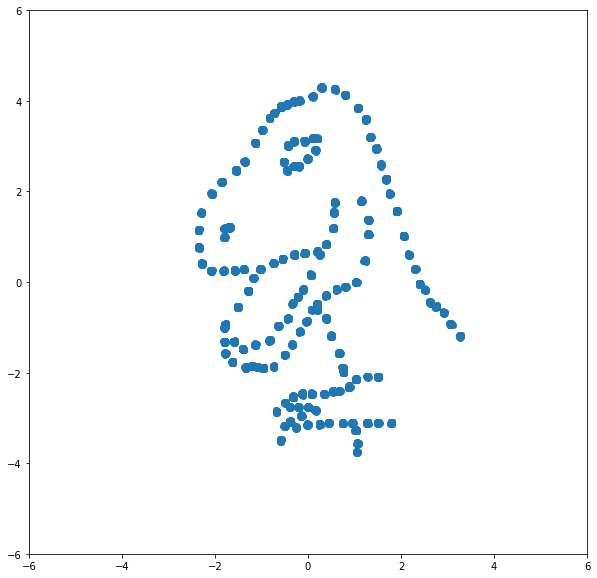

In [46]:
d, = dataloader.dataset[:,:]
plot_data(d)